## Simulate responses for arbitrary input (from the models trained on real data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from neuraldistributions.sampler import generate_n_samples
from neuraldistributions.utility import imread

### Load an arbitrary image

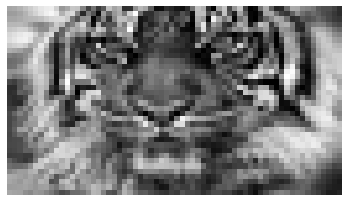

In [2]:
image_path = "/project/notebooks/arbitrary_image.jpg"
input_image = imread(image_path, xres=64, yres=36)

plt.imshow(input_image[0, 0], cmap="gray")
plt.axis("off");

### Load a trained model

In [3]:
model = torch.load("/project/models/ziffa_scan2")
device = next(model.parameters()).device

### Simulate responses

In [4]:
samples = generate_n_samples(model, image_path, n_samples=500)

100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


### Learned vs simulated portion of positive responses

In [5]:
mu, q = model(torch.from_numpy(input_image).to(device))
learned_q = q.cpu().data.numpy()
simulated_q = (samples >= model.zero_threshold.item()).sum(0) / samples.shape[0]

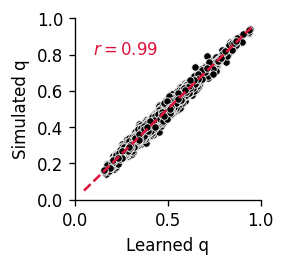

In [6]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=120)

corr_val = np.corrcoef(learned_q, simulated_q)[0, 1]

ax.plot([.05, .95], [.05, .95], ls="--", c='crimson', zorder=1)
ax.scatter(learned_q, simulated_q, s=20, c='k', ec='.95', lw=.5, zorder=0)
ax.text(.1, .8, fr"$r = {corr_val:.2f}$", color="crimson")
ax.set(xlim=(0, 1), xlabel="Learned q", 
       ylim=(0, 1), ylabel="Simulated q")
sns.despine(trim=True)

### Visualize the simulated responses

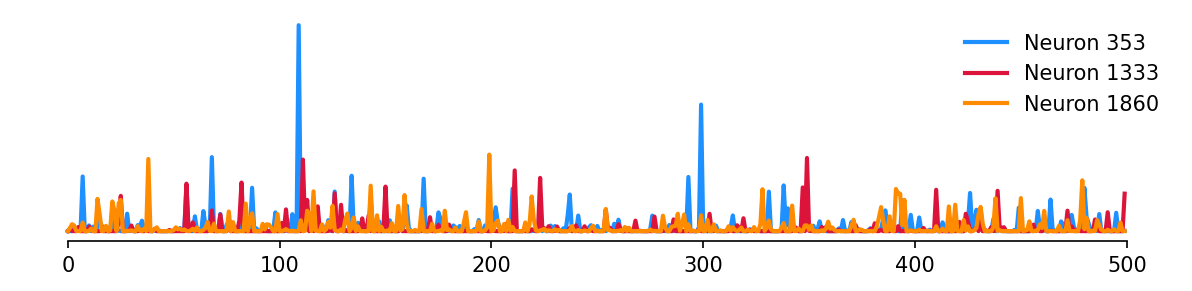

In [7]:
np.random.seed(42)
colors = ['dodgerblue', 'crimson', 'darkorange']
neuron_idx = np.random.choice(np.arange(samples.shape[1]), replace=False, size=3)
neuron_idx.sort()

fig, ax = plt.subplots(figsize=(10.0, 2.), dpi=150)

for i, s in enumerate(samples[:, neuron_idx].T):
    ax.plot(s, c=colors[i], lw=2, label=f"Neuron {neuron_idx[i]}");
ax.set(yticks=[])
ax.legend(frameon=False)
sns.despine(trim=True, left=True)